In [1]:
import pandas as pa
import numpy as np
import itertools
import csv


En tete a lire a chaque fois : les ID ne sont pas uniques, ça vient peut_etre des etoilllllllles je vais voir ce que je peux faire au pire j'en recrée.

edit : 
non, ça vient du fait que les TE sont morcelés, et du coup pour le meme te on garde la meme ID meme si les séquences sont discontinues. du coup je fais quoi je sais pas.

edit lundi 27 : 
j'ai recrée de nouvelle ID, ça devrait suffire pour faire fonctionner tout ça. 
(ça fonctionne effectivement, mais en l'état l'annotation n'est pas de bonne qualité. 

In [2]:
names_col_data = ['SW_score',"perc_div","perc_del","perc_ins", "query_seq", "pos_query_begin", "pos_query_end", "pos_query_left","strand", "matching_repeat", "repeat_class_family", "pos_in_repeat_begin", "pos_in_repeat_end", "pos_in_repeat_left", "TE_A_ID","star"]
data = pa.read_csv("/home/tkastylevsky/FASTA_files/repeatmasker/gallus_gallus/gallus_whole_cluster/whole/galgal6_whole.fa.out",header = None, skiprows = 2, sep = '\s+', names = names_col_data)
data['strand'] = data['strand'].replace('C','-')
data.insert(1,"A_ID",list(range(1,len(data)+1)))

data_split = data.repeat_class_family.str.split('/',expand = True)
data = data.join(data_split)
data.columns = ['SW_score','A_ID',"perc_div","perc_del","perc_ins", "query_seq", "pos_query_begin", "pos_query_end", "pos_query_left","strand", "matching_repeat", "repeat_class_family", "pos_in_repeat_begin", "pos_in_repeat_end", "pos_in_repeat_left", "TE_A_ID","star","repeat_class","repeat_family"]
data = data.drop('repeat_class_family', axis = 1)


In [3]:
data_intersect = data
data_intersect = data_intersect.drop(["SW_score","perc_del","perc_ins", "pos_query_left", "pos_in_repeat_begin", "pos_in_repeat_end", "pos_in_repeat_left", "star"], axis = 1 )
data_intersect.insert(1, "feature", "Similarity")
data_intersect.insert(1, "source", "RepeatMasker")
data_intersect.insert(1, "phase", ".")

data_intersect = data_intersect[['query_seq','source','feature','pos_query_begin','pos_query_end', 'perc_div', 'strand','phase', 'A_ID']]
data_intersect.to_csv('/home/tkastylevsky/FASTA_files/repeatmasker/gallus_gallus/gallus_whole_cluster/whole/galgal6_whole.fa.out.gff', sep = '\t', header = False, index = False)

In [4]:
#nombre de hit qui se superposent à un meilleur hit au sein d'un meme out. 
print(data.star.count())

13445


In [5]:
names_col_ref = ['SW_score',"perc_div","perc_del","perc_ins", "query_seq", "pos_query_begin", "pos_query_end", "pos_query_left","strand", "matching_repeat", "repeat_class_family", "pos_in_repeat_begin", "pos_in_repeat_end", "pos_in_repeat_left", "TE_B_ID","star"]

ref = pa.read_csv("/home/tkastylevsky/FASTA_files/repeatmasker/gallus_gallus/reference/galGal6.fa.out",header = None, skiprows = 2, sep = '\s+', names = names_col_ref)
ref['strand'] = ref['strand'].replace('C','-')
#ref_chr1 = ref[ref['query_seq']=='chr1']
#ref = ref_chr1
ref.insert(1,"B_ID",list(range(1,len(ref)+1)))
ref_split = ref.repeat_class_family.str.split('/',expand = True)
ref = ref.join(ref_split)
ref.columns = ['SW_score','B_ID',"perc_div","perc_del","perc_ins", "query_seq", "pos_query_begin", "pos_query_end", "pos_query_left","strand", "matching_repeat", "repeat_class_family", "pos_in_repeat_begin", "pos_in_repeat_end", "pos_in_repeat_left", "TE_B_ID","star","repeat_class","repeat_family"]


In [6]:
ref_intersect = ref
ref_intersect = ref_intersect.drop(["SW_score","perc_del","perc_ins", "pos_query_left","repeat_class_family", "pos_in_repeat_begin", "pos_in_repeat_end", "pos_in_repeat_left", "star"], axis = 1 )
ref_intersect.insert(1, "feature", "Similarity")
ref_intersect.insert(1, "source", "RepeatMasker")
ref_intersect.insert(1, "phase", ".")

ref_intersect =ref_intersect[['query_seq','source','feature','pos_query_begin','pos_query_end', 'perc_div', 'strand','phase', 'B_ID']]
ref_intersect.to_csv('/home/tkastylevsky/FASTA_files/repeatmasker/gallus_gallus/reference/galGal6.fa.out.gff', sep = '\t', header = False, index  = False)


Pour passer a la suite, il faut faire un détour par bedtools pour récupérer les intersections(ça m'a semblé plus pratique)

In [7]:
#results A match_raw combien de fois A match dans B, sans tenir compte du type ni de la longueur des matchs. 

results = pa.read_csv("/home/tkastylevsky/results/results_bedtools/chk_galGal6_chr1_sequence.out_compared_to_ref.txt",header = None, sep = '\s+')
results = results.drop([0,1,2,5,6,7,9,10,11,14,15,16], axis = 1)
names_col_2 = ['A_start','A_end','A_ID','B_start','B_end','B_ID','intersect']
results.columns = names_col_2

results['intersect_A'] = results['intersect']/(results['A_end']-results['A_start'])
results['intersect_B'] = results['intersect']/(results['B_end']-results['B_start'])





Deux petits graphes qui résument les pourcentages d'identité entre les matchs. J'ai ai fais un en logscale 

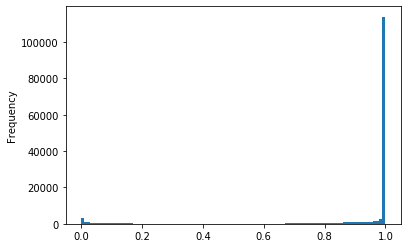

In [9]:
plot = results.intersect_A.plot.hist(bins = 100)


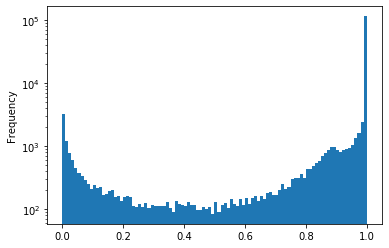

In [10]:
plot = results.intersect_A.plot.hist(bins = 100)
plot.set_yscale('log')


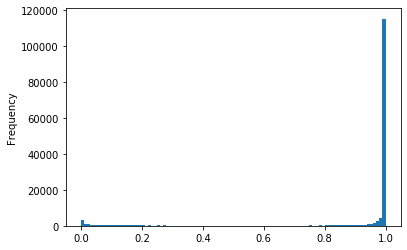

In [11]:
plot = results.intersect_B.plot.hist(bins = 100)


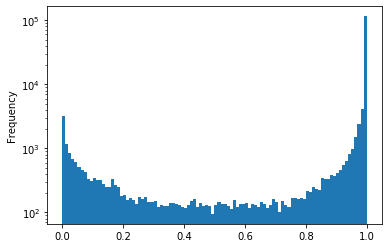

In [12]:
plot = results.intersect_B.plot.hist(bins = 100)
plot.set_yscale('log')


On va regarder le pourcentage de hits pour nos données et la ref dans le bedtools intersect. 

In [13]:
ID_A = pa.DataFrame(list(range(1,len(data)+1)))
ID_B = pa.DataFrame(list(range(1,len(ref)+1)))
#ID_A.A_ID.isin(ID_A)]
ID_A.columns = ['ID']
ID_B.columns = ['ID']

A_presence = ID_A[ID_A.ID.isin(results.A_ID)]
B_presence = ID_B[ID_B.ID.isin(results.B_ID)]
A_absence = ID_A[~ID_A.ID.isin(results.A_ID)]
B_absence = ID_B[~ID_B.ID.isin(results.B_ID)]


on va juste regarder rapidement comment ça change lorsque l'on demande a bedtools d'etre plus stringeant sur ses intersections. (on accepte que les hits a 80% reciproques)

In [14]:
results_best = pa.read_csv("/home/tkastylevsky/results/results_bedtools/chk_galGal6_chr1_sequence.out_compared_to_ref_80.txt",header = None, sep = '\s+')
results_best = results_best.drop([0,1,2,5,6,7,9,10,11,14,15,16], axis = 1)
results_best.columns = names_col_2
results_best
A_presence_best = ID_A[ID_A.ID.isin(results_best.A_ID)]
B_presence_best = ID_B[ID_B.ID.isin(results_best.B_ID)]
A_absence_best = ID_A[~ID_A.ID.isin(results_best.A_ID)]
B_absence_best = ID_B[~ID_B.ID.isin(results_best.B_ID)]
print(len(A_presence), 'VS', len(A_presence_best))
print(len(B_presence), 'VS', len(B_presence_best))
print(len(A_absence), 'VS', len(A_absence_best))
print(len(B_absence), 'VS', len(B_absence_best))

139522 VS 121825
131681 VS 118330
23906 VS 41603
18546 VS 31897


In [15]:
#des petits pourcentages sur les totaux: 
perc_hit_A = len(A_presence)/(len(A_presence)+len(A_absence))
perc_hit_B = len(B_presence)/(len(B_presence)+len(B_absence))

perc_hit_A_best = len(A_presence_best)/(len(A_presence_best)+len(A_absence_best))
perc_hit_B_best = len(B_presence_best)/(len(B_presence_best)+len(B_absence_best))

print(perc_hit_A, 'VS', perc_hit_A_best )
print(perc_hit_B, 'VS', perc_hit_B_best )

0.853721516508799 VS 0.7454352987248207
0.8765468258036172 VS 0.7876746523594294


on s'attaque au type matching ! yay ! 

edit : 

lundi 27 janvier,  il y a un soucis dans le results_type, qui vient sans doute du merge et de la façon dont il est fait (il est beaucoup trop petit)


edit : c'est corrigé. il fallait faire un "inner" et pas un "outer"

In [16]:
results_type = results.drop(['intersect'], axis = 1)
results_type = pa.merge(results_type, data, on = 'A_ID', how = 'inner')
results_type = results_type[['A_ID','B_ID','intersect_A','intersect_B', 'matching_repeat','repeat_class','repeat_family','TE_A_ID']]
results_type.columns = ['A_ID','B_ID','intersect_A','intersect_B', 'matching_repeat_A', 'repeat_class_A','repeat_family_A','TE_A_ID']
ref_type = ref[['B_ID','matching_repeat', 'repeat_class','repeat_family','TE_B_ID']]
ref_type.columns = ['B_ID','matching_repeat_B','repeat_class_B','repeat_family_B','TE_B_ID']


results_type = pa.merge(results_type, ref_type, on = 'B_ID', how = 'inner')

results_type.to_csv('/home/tkastylevsky/results/bedtools_analysis/chk_galgal6_chr1_repeat_fam_intersect.csv',sep = '\t', index = False)



Pour la suite, voir le code R bedtools display, pour se faire une idée générale de la qualité de l'annotation (pas bonne). c'est trèèèèèèèèèèèsssssss long d'essayer de le faire sur Python. 

In [39]:
ans = results_type.groupby('A_ID').apply(lambda grp: grp.nlargest(1,'intersect_A'))


Index(['A_ID', 'B_ID', 'intersect_A', 'intersect_B', 'matching_repeat_A',
       'repeat_class_A', 'repeat_family_A', 'TE_A_ID', 'matching_repeat_B',
       'repeat_class_B', 'repeat_family_B', 'TE_B_ID'],
      dtype='object')